<a href="https://colab.research.google.com/github/prabhu2599/OpenCV-ProEdging/blob/master/License_Plate_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
20MAI1001
PRABHU GANTAYAT
```



# **License plate recognition**



```
# We are using Yolo for the localization of the number plate and tesseract and 
openCV to extract the Alpha-Numeric characters from number plate.
```



In [1]:
!git clone https://github.com/misbah4064/yolo-license-plate-detection.git
%cd yolo-license-plate-detection
!gdown https://drive.google.com/uc?id=1vXjIoRWY0aIpYfhj3TnPUGdmJoHnWaOc

Downloading...
From: https://drive.google.com/uc?id=1vXjIoRWY0aIpYfhj3TnPUGdmJoHnWaOc
To: /content/model.weights
245MB [00:01, 151MB/s]


In [ ]:
import cv2
import numpy as np

def objectDetector(img):
    yolo = cv2.dnn.readNet("model.weights", "darknet-yolov3.cfg")
    classes = []

    with open("classes.names", "r") as file:
        classes = [line.strip() for line in file.readlines()]
    layer_names = yolo.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in yolo.getUnconnectedOutLayers()]

    colorRed = (0,0,255)
    colorGreen = (0,255,0)
    colorWhite = (255,255,255)

    height, width, channels = img.shape

    ## Here we are trying to detect the bounding boxes from the image on whcih we will iterate after wards.
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

    yolo.setInput(blob)
    outputs = yolo.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            cv2.rectangle(img, (x, y), (x + w, y + h), colorGreen, 3)
            cv2.putText(img, label, (x, y - 30), cv2.FONT_HERSHEY_PLAIN, 3, colorWhite, 2)
    return img

# We will now try with a number plate from our data. And test our model's performance.

*Yolo is used for localization is we see it's working perfectly.*

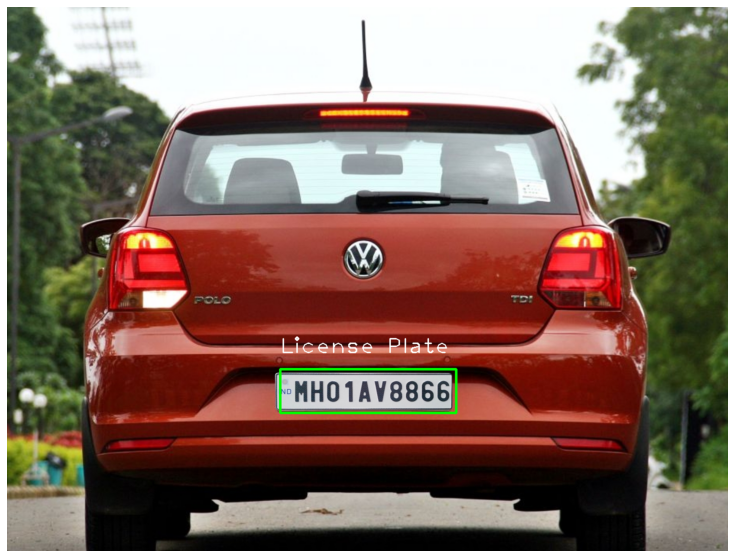

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

input_image = cv2.imread("/content/6-Heres-The-Reason-Behind-Indian-Vehicles-Different-Coloured-Number-Plates..jpg")
image = objectDetector(input_image)
height, width = image.shape[:2]
resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis("off")
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.show()

## Using **pytesseract** for the text *extraction*

In [ ]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (5,464 kB/s)
debconf: unable to initi

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import pytesseract

# Read the image file
image = cv2.imread("/content/6-Heres-The-Reason-Behind-Indian-Vehicles-Different-Coloured-Number-Plates..jpg")
# Convert to Grayscale Image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Canny Edge Detection
canny_edge = cv2.Canny(gray_image, 170, 200)

# Find contours based on Edges
contours, new  = cv2.findContours(canny_edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours=sorted(contours, key = cv2.contourArea, reverse = True)[:30]

# Initialize license Plate contour and x,y coordinates
contour_with_license_plate = None
license_plate = None
x = None
y = None
w = None
h = None

# Find the contour with 4 potential corners and creat ROI around it
for contour in contours:
        # Find Perimeter of contour and it should be a closed contour
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.01 * perimeter, True)
        if len(approx) == 4: #see whether it is a Rect
            contour_with_license_plate = approx
            x, y, w, h = cv2.boundingRect(contour)
            license_plate = gray_image[y:y + h, x:x + w]
            break

# Removing Noise from the detected image, before sending to Tesseract
license_plate = cv2.bilateralFilter(license_plate, 11, 17, 17)
(thresh, license_plate) = cv2.threshold(license_plate, 150, 180, cv2.THRESH_BINARY)

#Text Recognition
text = pytesseract.image_to_string(license_plate)

# While extracting text we see we get some extra characters getting introduced which are not required.

```
# ['»', '\n', '\x0c']
```

### ***These need to be eliminated.***


In [ ]:
text = [i for i in text if i.isalnum()]
text = ''.join(text)
print(text)

MHO1AV8866


In [ ]:
['»', '\n', '\x0c']

# Printing the number plate and the digits on the image.

License Plate : MHO1AV8866


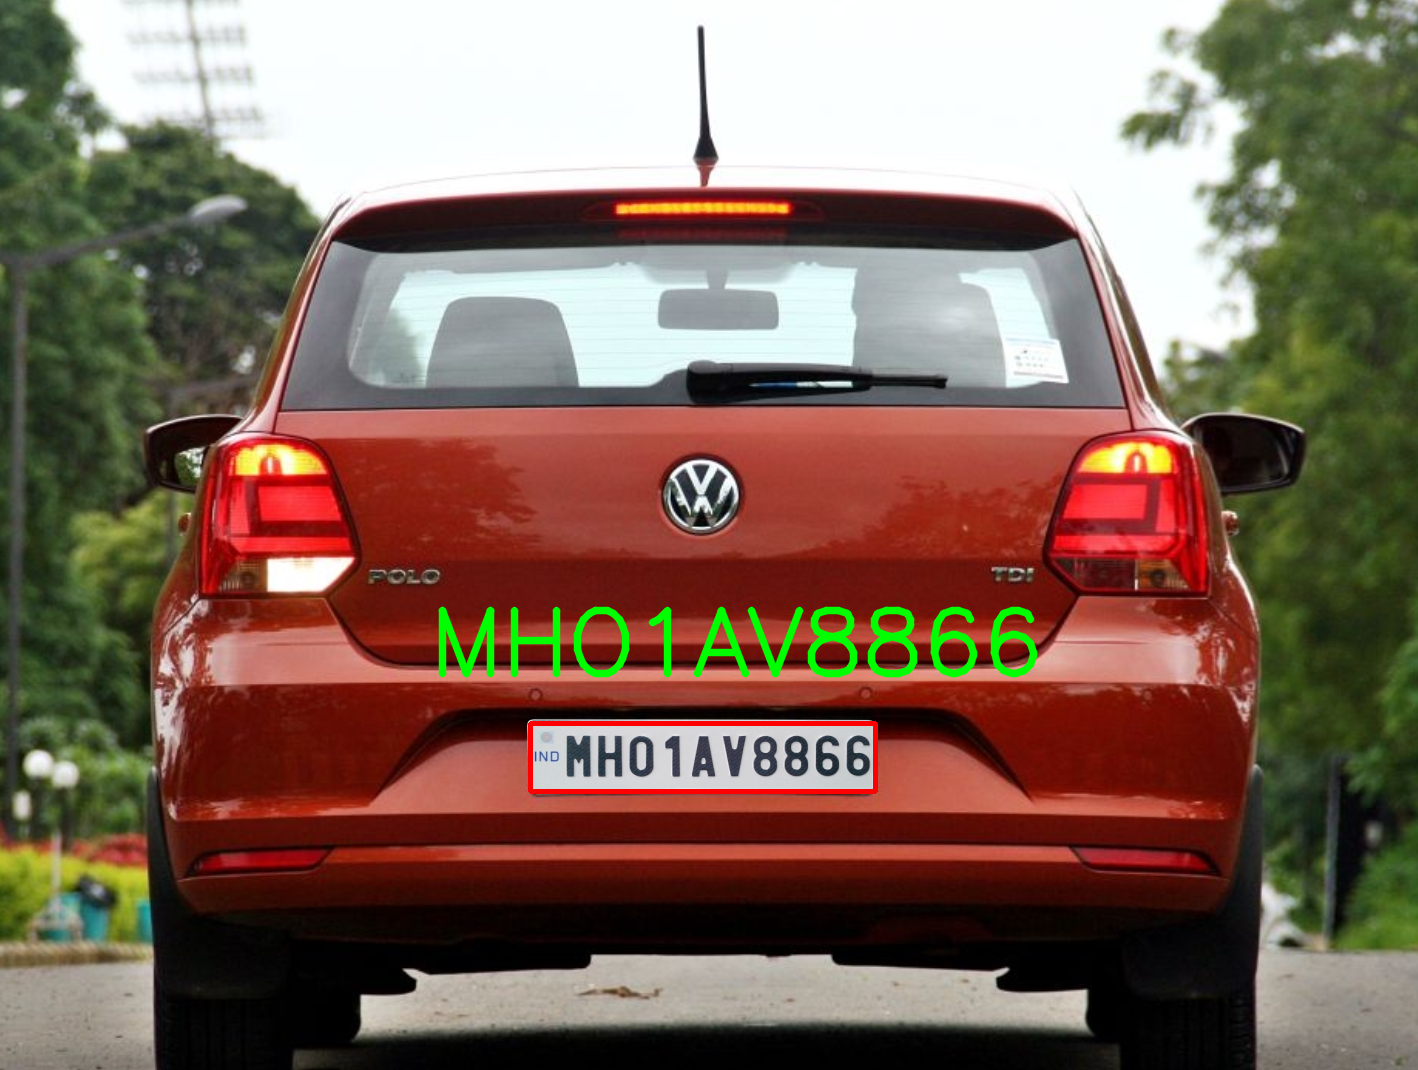

In [ ]:
#Draw License Plate and write the Text
image = cv2.rectangle(image, (x,y), (x+w,y+h), (0,0,255), 3) 
image = cv2.putText(image, text, (x-100,y-50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,255,0), 6, cv2.LINE_AA)

print("License Plate :", text)
cv2_imshow(image)

# **Conclusion:**

### We did the number plate localization and recognition, and for that we used Yolo with pre trained weights and pyTesseract for text extraction.